# Predicting red wine prices from SAQ.com (Société des alcools du Québec)

<br>

**Objective**: The goal of this machine learning project is to develop a model that can predict red wine prices using SAQ data. We will also interpret the results to find the variables that are most predictive.

<br>

## Problem definition

In this post, we will build a regression model in order to predict red wine prices. We will get the data from SAQ website (Société des alcools du Québec). To do so, we will first extract the data from <a href="https://www.saq.com/content/SAQ/fr.html"> SAQ.com</a>. Once we get the data that we need, we will build our regressor model to predict red wine prices.

In this machine learning pipeline, we will :
- Extract & uploading data
- Exploratory Data Analysis (EDA)
- Naive Baseline
- Feature Engineering & Model Selection
- Model Evaluation on test data
- Model Analysis (Interpretability)
- Conclusion

Note that the dataset has approximately 5000 rows. Our metric evaluation will be MAE. Feel free to see my repository on <a href="https://github.com/louiswillems/saq-price-predictions"> Github</a>.

*Important: For the purpose of our project, we will follow these steps in a linear fashion but machine learning pipeline is an iterative procedure.*






<br>

## Preparing environment & uploading data

Import packages


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import FunctionTransformer
import category_encoders as ce
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
from sklearn.model_selection import learning_curve

from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import re
import io
import time
import d6tpipe
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

%config InlineBackend.figure_format ='retina'

random_state= 42
scoring_metric = 'neg_mean_absolute_error'

api = d6tpipe.api.APIClient()
api.setToken('<Your Token>') # Your Token
api.list_pipes()
pipe = d6tpipe.Pipe(api, 'saqredwine2019')
pipe.pull() 

# Drop unnecessary column: Unnamed: 0
cols = list(pd.read_csv(pipe.dirpath/'saq_redwine_5000_GCP2.csv', nrows =1))
df = pd.read_csv(pipe.dirpath/'saq_redwine_5000_GCP2.csv', usecols =[i for i in cols if i != 'Unnamed: 0']).astype({'Size':object})
df

It's a clean, easy to understand set of data. Here's what all the features mean:

- **Country**: Country of origin
- **Region**: Region where the wine was made
- **Designation**: Product of a single vineyard with that vineyard's name appearing on the wine label.
- **Producer**: Wine-producer
- **Size**: Volume in mL or L (7500 mL, 1.5L)
- **Alcohol**: Degree of Alcohol (%)

In [2]:
def prepare_data(data, target_name):
    """
    Separate X, y 
    Separate numerical and categorical columns.
    """
    # != 0 & NaN on Target
    data = data.loc[data[target_name] != 0]
    data.dropna(subset= [target_name], inplace=True)

    if target_name is not None:
        X = data.drop(target_name, axis=1)
        y = data[target_name]
        
        # get list of numerical & categorical columns in order to process these separately in the pipeline 
        num_cols = X.select_dtypes("number").columns
        cat_cols = X.select_dtypes("object").columns
    else:
        X = data
        y = None
    return X, y, num_cols, cat_cols

# retrieve X, y and separated columns names for numerical and categorical data
X, y, num_cols, cat_cols = prepare_data(df, 'Price')

# Split train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

## Exploratory Data Analysis

- Check if data is intuitive 
- Missings values
- Outliers
- Linear Relationships
- Cross-Validation Startegy

In [3]:
# Stats
stats = pd.DataFrame(columns = ['Columns','Types','Values', 'Uniques', 'Uniques(no nulls)', 'Missing(n)', 'Missing(%)'])
eda = pd.DataFrame()

for c in X_train.columns:
    eda['Columns'] = [c]
    eda['Types'] = X_train[c].dtypes
    eda['Values'] = [X_train[c].unique()]
    eda['Uniques'] = len(list(X_train[c].unique()))
    eda['Uniques(no nulls)'] = int(X_train[c].nunique())
    eda['Missing(n)'] = X_train[c].isnull().sum()
    eda['Missing(%)'] = (X_train[c].isnull().sum()/ len(X_train)).round(3)*100
    stats = stats.append(eda)
    
stats

,Columns,Types,Values,Uniques,Uniques(no nulls),Missing(n),Missing(%)
0,Name,object,[Domaine Simon Bize et Fils Savigny-les-Beaune...,3650,3650,0,0.0
0,Country,object,"[France, NewZealand, Italy, Greece, Argentina,...",31,31,0,0.0
0,Region,object,"[Bourgogne, NorthIsland, Piedmont, None, Langu...",101,100,77,2.1
0,Designation,object,[(AOC/AOP)Appellationoriginecontrolée/protégée...,35,34,12,0.3
0,Producer,object,"[Savigny-lès-Beaune Premier Cru, Craggy Range ...",967,967,0,0.0
0,Size,object,"[750.0, 1.5, 1.0, 4.0, 500.0, 375.0, 3.0, 250....",9,9,0,0.0
0,Alcohol,float64,"[13.0, 13.5, 14.5, 13.6, nan, 14.0, 14.2, 12.5...",62,61,557,15.1


### Price Distribution

count    3687.000000
mean       60.766653
std        95.681428
min         4.300000
25%        19.950000
50%        29.000000
75%        59.250000
max       989.500000
Name: Price, dtype: float64

 mu = 60.77 and sigma = 95.67



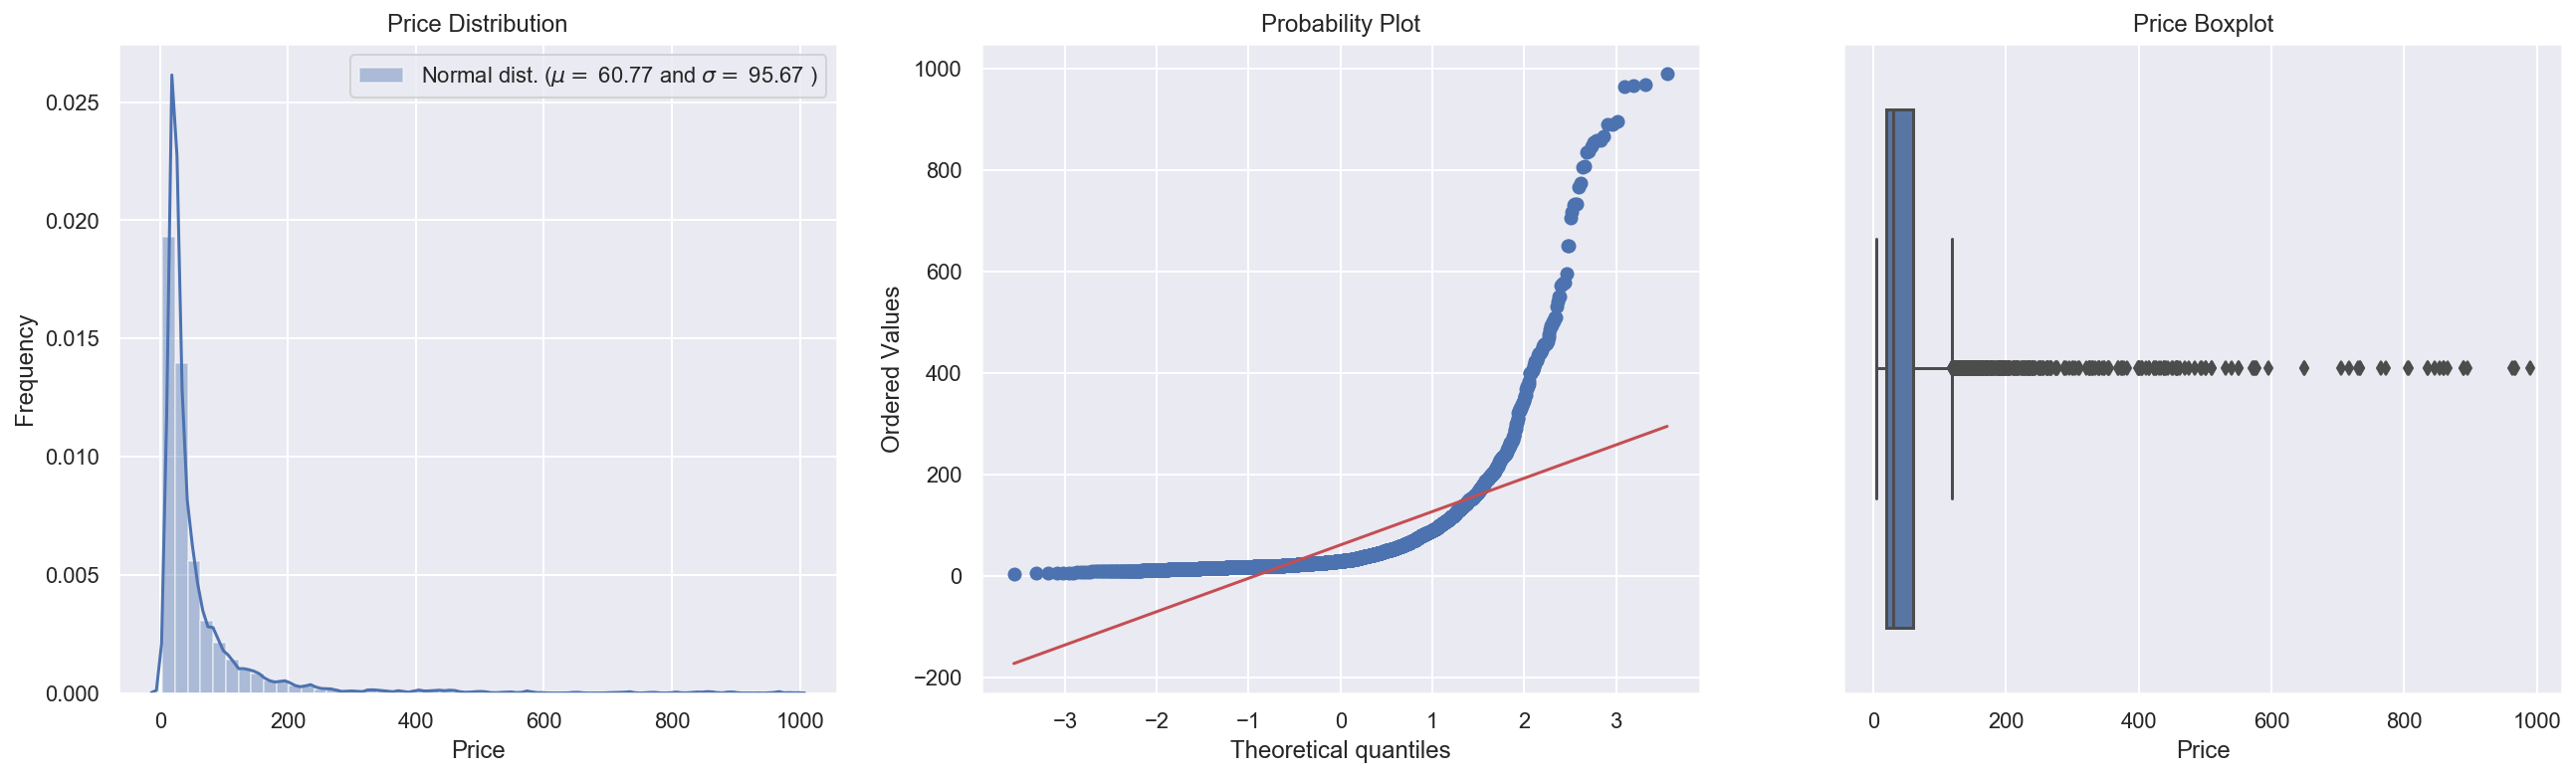

5.046726389526432

In [4]:
from scipy import stats
from scipy.stats import norm, skew

# Target describe()
print(y_train.describe())
         
plt.figure(figsize=(22,6))

plt.subplot(1,3,1)
sns.distplot(y_train, bins=50)
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Price Distribution')

plt.subplot(1,3,2)
stats.probplot(y_train, plot=plt)

plt.subplot(1,3,3)
sns.boxplot(y_train)
plt.title('Price Boxplot')
plt.show()
stats.skew(y_train)
# save jpeg
# bplot.figure.savefig('price_boxplot.jpg', format='jpeg') 

So, with 5.0 of positive kurtosis `Price` are definitely heavy-tailed and has some outliers that we need take care. In this case of positive skewness, log transformations usually works well.

### Log Transformed Price Distribution


 mu = 3.65 and sigma = 0.84



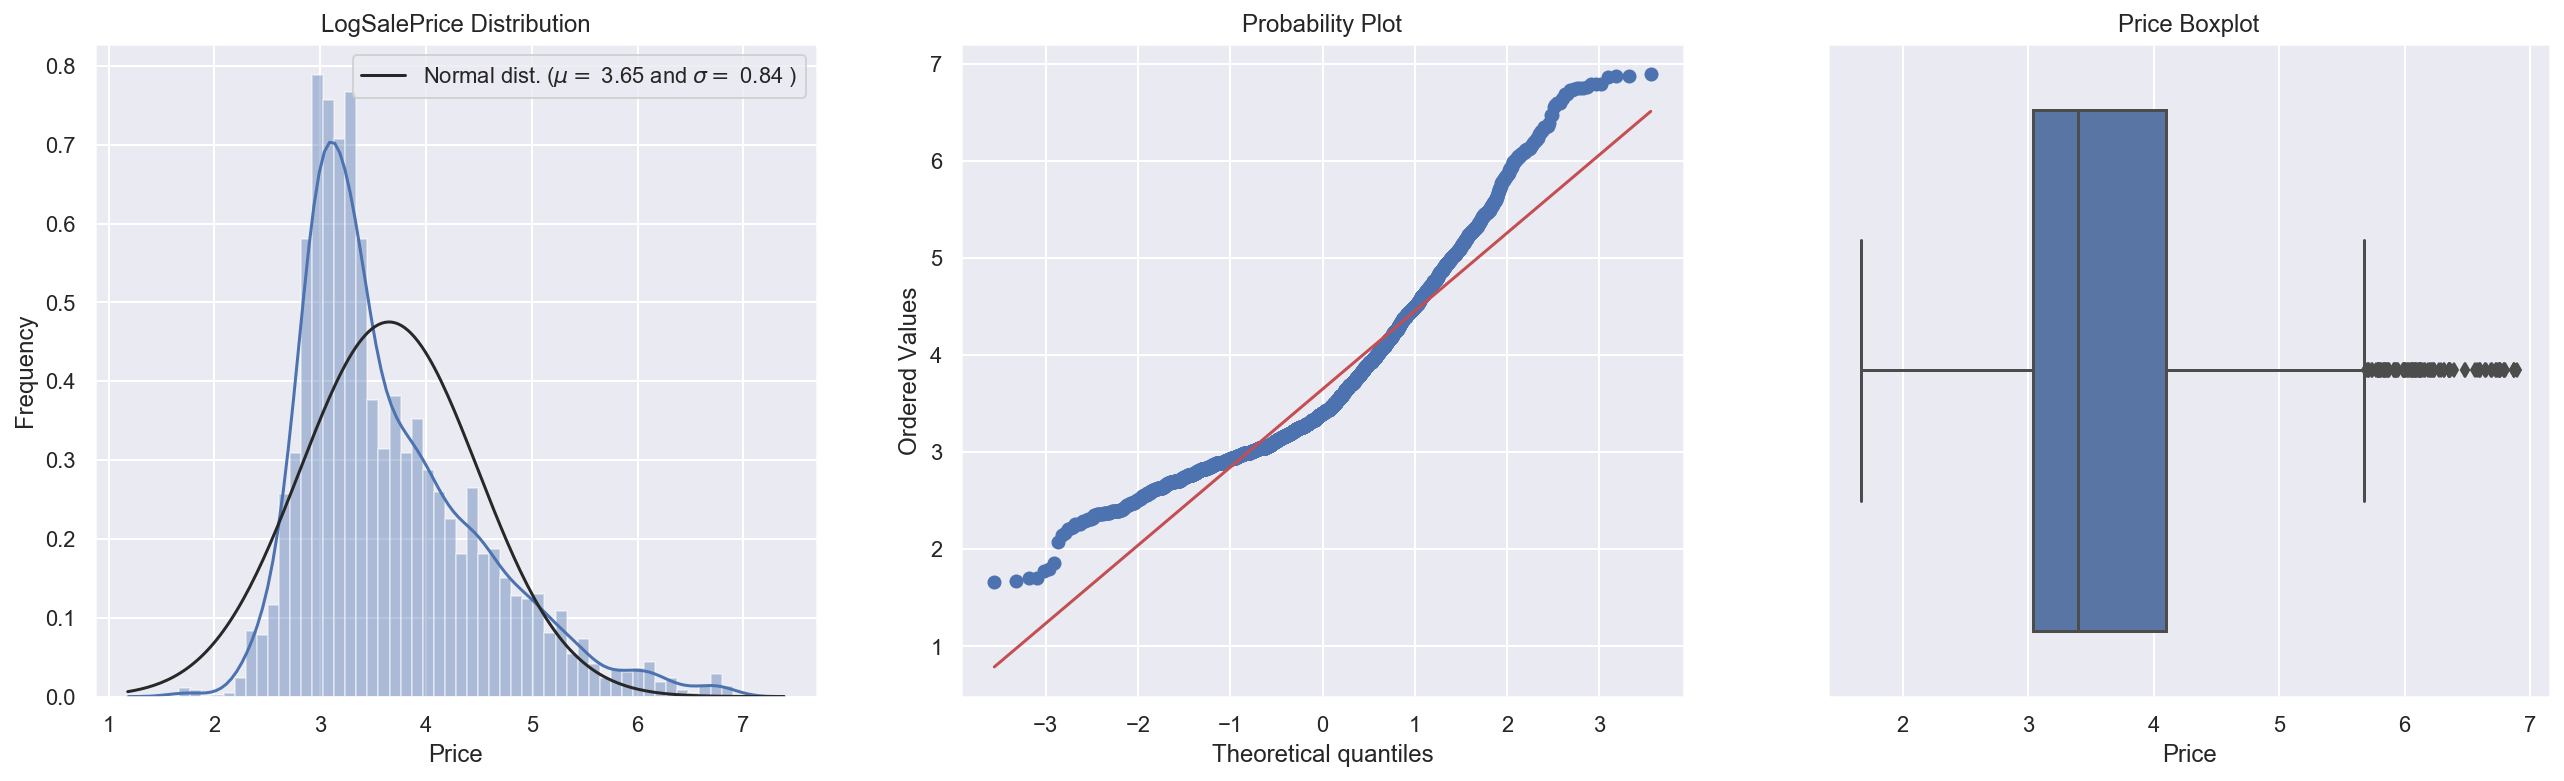

1.1045259289240887

In [6]:
# Log transformation on Price
ylog_train = np.log1p(y_train)

# Plot
plt.figure(figsize=(22,6))

plt.subplot(1,3,1)
sns.distplot(ylog_train, bins=50, fit=norm)
(mu, sigma) = norm.fit(ylog_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('LogSalePrice Distribution')

plt.subplot(1,3,2)
stats.probplot(ylog_train, plot=plt)

plt.subplot(1,3,3)
sns.boxplot(ylog_train)
plt.title('Price Boxplot')
plt.show()
stats.skew(ylog_train)

### Categorical & Numerical Features: Linear Relationships

In [7]:
# Select the numeric columns
numeric_subset = X_train.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'Price':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = X_train[['Country', 'Region', 'Designation', 'Producer', 'Size']]
# # One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

features = pd.concat([numeric_subset, categorical_subset, y_train], axis = 1)
# Find corr
correlations = features.corr()['Price'].sort_values()

In [8]:
# Top 10 negative correlations
correlations.head(10)

Size_750.0                                                     -0.112079
Designation_Tablewine                                          -0.101213
Designation_Denominacióndeorigen(DO)                           -0.095398
Designation_DOP/DOCDenominazionediorginecontrollata/protetta   -0.086210
Country_Spain                                                  -0.081953
Region_Languedoc-Roussillon                                    -0.077925
Country_Argentina                                              -0.065159
Designation_Indicationgéographique(IG)                         -0.058148
Country_Chile                                                  -0.058143
Country_Portugal                                               -0.057867
Name: Price, dtype: float64

In [9]:
# Top 10 positive correlations
correlations.tail(10)

Country_France                                               0.130742
Producer_Saint-Emilion Grand Cru                             0.136298
Producer_Barolo                                              0.136889
Size_1.5                                                     0.142948
Designation_(AOC/AOP)Appellationoriginecontrolée/protégée    0.152574
Producer_Howell Mountain                                     0.156154
Producer_Napa Valley                                         0.168847
Region_Bourgogne                                             0.186852
Producer_Pauillac                                            0.219146
Price                                                        1.000000
Name: Price, dtype: float64

There are no strong positive linear relationships although we do see that `Producer` is slightly positively correlated with target `Price`.

<br>

**EDA Conclusions:**
- Almost all features are categoricals
- `Region`, `Designation`, `Alcohol` and our target `Price` have missing values
- `Alcohol` have more than 16% missing values
- `Name` act as an ID column but have some interesting values as text feature
- High number of uniques categorical values: `Producer` and `Region`
- Target `Price` distribution varies by `Producer`

## Naive Baseline



For our naive baseline, we will use the median value of `Price` on the training set for all observations on the test set. We will then calculate MAE to jauge the improuvement of our final model. So, our model will need to beat our naive baseline performance.


### Mean Absolute Error (MAE)

In [10]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

print("Naive Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, np.median(y_train)))

Naive Baseline Performance on the test set: MAE = 43.2902


In [6]:
# Numeric: Alcohol
numeric_transformer = Pipeline([
    ('imput', SimpleImputer(strategy='mean'))])


# Categorical: Country, Region, Designation, Producer, Size
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) # use OneHotEncoder(handle_unknown='ignore') to ignore new categories in test set
    

# ColumnTransformer
cat_feat = ['Country', 'Region', 'Designation', 'Producer', 'Size']
num_feat = ['Alcohol']


column_trans = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feat),
        ('cat', categorical_transformer, cat_feat)])


lr = Pipeline([('column_trans', column_trans),
               ('LinearRegression', LinearRegression())])

rf = Pipeline([('column_trans', column_trans),
               ('RandomForestRegressor', RandomForestRegressor(random_state=random_state))])

sdg = Pipeline([('column_trans', column_trans),
               ('SGDRegressor', SGDRegressor(loss='squared_loss', random_state=random_state))])

gbr = Pipeline([('column_trans', column_trans),
               ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=random_state))])

lsvr = Pipeline([('column_trans', column_trans),
               ('LinearSVR', LinearSVR(random_state=random_state))])

cat = Pipeline([('column_trans', column_trans),
               ('CatBoostRegressor', CatBoostRegressor(verbose=1000, random_seed=random_state))])



# Setting up Cross-Validation
scores = []
results = []
names = []

cv = KFold(n_splits=5, shuffle=True, random_state=5)

for est, name in zip((lr, rf, sdg, gbr, lsrv, cat),
                     ('LinearRegression', 'RandomForestRegressor', 'SGDRegressor', 'GradientBoostingRegressor', 'LinearSVR', 'CatBoostRegressor')):

    start_time = time.time()         


    # crossvalidate classifiers on training data
    cv_score = cross_val_score(est, X=X_train, y=y_train, cv=cv, scoring=scoring_metric)

    # cross_validate vs cross_val_score

    scores.append([name.strip(), -1*cv_score.mean(), cv_score.std(), (time.time() - start_time)])
    results.append(cv_score)
    names.append(name)

scores = pd.DataFrame(scores, columns=["Regressor", 'MAE', '+/-', 'Time(s)']).sort_values('MAE', ascending=True)
# scores.style.highlight_min()
scores

Most of our models outperform our naive baseline. Now, we will compare our models with some feature engineering and hyperparameter tuning.

*Important: Scikit-Learn version is generally slower than the XGBoost version, but here we'll stick to Scikit-Learn because the syntax is more familiar.*

## (Light) Feature Engineering & Model Selection

<br>

- Create a new feature `Year` from `Name`
- Impute missing values from numerical and categorical features
- Quantile Binning on `Alcohol`
- One-hote encoding categorical features
- Apply log-transform to `Price` since target is skewed
- Evaluation using Nested Cross-validation (5x2-fold): *Inner loop is responsible for hyperparameters tuning and model selection, and the outer loop is used to evaluate the model selected by the inner loop*

In [1]:
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin

class YearTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.str.extract('(20\d{2})', expand=True).replace(np.nan, 'Other', regex=True)


# Numeric: Quantile based Adaptative Binning on Alcohol variable
numeric_transformer = Pipeline([
    ('imput', SimpleImputer(strategy='mean')),
    ('KBinsDiscretizer', KBinsDiscretizer(n_bins=4, encode='onehot', strategy='quantile'))])

# Categorical: Country, Region, Designation, Producer, Size
categorical_transformer = Pipeline([
    ('imput', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Categorical: Name -> Year
year_transformer = Pipeline([
 ('year', YearTransformer()),
 ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# ColumnTransformer
cat_feat = ['Country', 'Region', 'Designation', 'Producer', 'Size']
num_feat = ['Alcohol']
year_feat = 'Name'

column_trans = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feat),
        ('cat', categorical_transformer, cat_feat),
        ('year', year_transformer, year_feat)])

rf = Pipeline([('column_trans', column_trans),
               ('RandomForestRegressor', RandomForestRegressor(random_state=random_state))])

sdg = Pipeline([('column_trans', column_trans),
               ('SGDRegressor', SGDRegressor(loss='squared_loss', random_state=random_state))])

gbr = Pipeline([('column_trans', column_trans),
               ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=random_state))])

lsrv = Pipeline([('column_trans', column_trans),
               ('LinearSVR', LinearSVR(random_state=random_state))])

cat = Pipeline([('column_trans', column_trans),
               ('CatBoostRegressor', CatBoostRegressor(verbose=1000, random_seed=random_state))])


# Model hyperparameters & tuning space
param_grid_rf  = [{'RandomForestRegressor__max_features': [4, 5, 6],
                   'RandomForestRegressor__n_estimators':[100, 200, 300]}]

param_grid_sdg = [{'SGDRegressor__alpha': [1e-5, 1e-4, 1e-3]}]

param_grid_gbr = [{'GradientBoostingRegressor__n_estimators' : [900, 1000],
                    'GradientBoostingRegressor__max_depth' : [5, 6, 7]}]

param_grid_lsvr = [{'LinearSVR__C':[17, 18, 19, 20]}]

param_grid_cat = [{'CatBoostRegressor__iterations':[1000, 1600],
                   'CatBoostRegressor__depth': [8, 12],
                   'CatBoostRegressor__bagging_temperature': [2, 3]}]


# Multiple GridSearchCV objects, one for each algorithm
gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True, random_state=random_state)

for pgrid, est, name in zip((param_grid_rf, param_grid_sdg, param_grid_gbr, param_grid_lsvr, param_grid_cat),
                            (rf, sdg, gbr, lsrv, cat),('RandomForestRegressor', 'SGDRegressor', 'GradientBoostingRegressor', 'LinearSVR', 'CatBoostRegressor')):

    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring_metric,
                       n_jobs=1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
outer_scores = {}

results = []
names = []

for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train, 
                                   y=y_train, 
                                   cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer  {-1*nested_score.mean():.2f} +/- {nested_score.std():.2f}')

    results.append(nested_score)
    names.append(name)

fig = plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

Generally, Random Search is better when we have limited knowledge of the best model hyperparameters and we can use Random Search to narrow down the options and then use Grid Search with a more limited range of options. Bayesian optimization methods are better for large datasets.



## Model Evaluation on Test Data

Now, we will select and use the best model from hyperparameter tuning in order to estimate the generalization performance on the test set. If this generalization error is similar to the validation error, we have reason to believe that our model will perform well on unseen data.

In order to estimate how the model performance varies with training set size, we will also plot the **Learning curve** for our model.

In [ ]:
gcv_model_select = GridSearchCV(estimator=gbr,
                                param_grid=param_grid_gbr,
                                scoring=scoring_metric,
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)
best_model = gcv_model_select.best_estimator_
print('Best Parameters: %s' % gcv_model_select.best_params_)

In [ ]:
best_model = Pipeline([('column_trans', column_trans), ('GradientBoostingRegressor',
                                                        TransformedTargetRegressor(regressor = GradientBoostingRegressor(n_estimators= 900, max_depth=6, random_state=random_state),
                                                                                   func=np.log1p, inverse_func=np.expm1))])
best_model.fit(X_train, y_train)

train_MAE = mean_absolute_error(y_true=y_train, y_pred=best_model.predict(X_train))
test_MAE = mean_absolute_error(y_true=y_test, y_pred=best_model.predict(X_test))

print(f'Training Mean absolute Error: {train_MAE:.2f}')
print(f'Test Mean Absolute Error: {test_MAE:.2f}')

### **Learning curves** 

With Learning curves we will estimate the variation of our model performance with training set size


In [ ]:
def plot_learning_curve(estimator, clf, X, y, ylim=None, cv=None, train_sizes=None):
    plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'Learning Curve ({clf})')
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.grid(True)
    return


best_model = Pipeline([('column_trans', column_trans), ('GradientBoostingRegressor', 
                                                        TransformedTargetRegressor(regressor = GradientBoostingRegressor(n_estimators= 900, max_depth=6, random_state=random_state),
                                                                                   func=np.log1p, inverse_func=np.expm1))])

train_sizes = np.linspace(.1, 1.0, 10)
ylim = (0.2, 1.01)
cv = 2
plot_learning_curve(best_model, 'GradientBoostingRegressor', X_train, y_train, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)

plt.show()


Looking at the plot above, we can see two distinct trends. As the number of training samples grows, the training set declines but we observe an improving generalization on the test set.

Also, the training score is greater than the validation score for the maximum number of training samples, so adding more training samples will most likely increase generalization.


To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values.

### **Density plot of predictions**

In [ ]:
final_predictions = best_model.predict(X_test)

# Density plot of the final predictions and the test values
plt.figure(figsize=(22,6))
sns.kdeplot(final_predictions, label = 'Predicted values')
sns.kdeplot(y_test, label = 'Test values')

# Label the plot
plt.xlabel('Price'); plt.ylabel('Density');
plt.title('Final Predictions & Test Values');

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median.

## Model Analysis (Interpretability)

In this section, we will try to understand how the model makes predictions.

**What features in the data did the model think are most important?**

In [ ]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(cat_feat)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name 


# Feature importances into a dataframe
pipeline = Pipeline([('column_trans', column_trans),
                     ('GradientBoostingRegressor',GradientBoostingRegressor(n_estimators= 900, max_depth=6, min_samples_leaf= 5, random_state=random_state))])
pipeline.fit(X_train, y_train)

feature_results = pd.DataFrame({'feature': get_column_names_from_ColumnTransformer(column_trans), 
                                'importance': pipeline.steps[1][1].feature_importances_})

feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

# Top 20 features 
sns.set()
plt.figure(figsize=(17,5))
plt.title(f'Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_results.head(20), orient='h', color = 'b')

The importance score assigned to each feature is a measure of how often that feature was selected, and how much of an effect it had in reducing impurity when it was selected. Since we one-hot encode most of our categorical features the resulting sparsity ensures that our continuous variable `Alcohol` is assigned higher feature importance. 

We need to consider others interpretability methods (Permutation importance or SHAP values) in order to  help combat the preference for continuous variables over binary ones.

## Conclusions


**How did we do?**

Not so great. 

Looking to our Learning curve, it seems that we can improve generalization with more training samples. We could also test and add new variables to our dataset. It could be data from red wine descriptions in order to do some text analysis. 

<br>

**Why even do this?**

*How can SAQ make more money from predicting red wine prices?*

Our idea of text description could help. We could look into the relationship between text description or wine critics and price. If we can identify certain words or characteristics of a text associated with expensive wines, then the SAQ could price its red wines accordingly.

<br>

**Communicated results in 30 seconds**

We need to go deeper and look into the relationship between red wine descriptions/critics data and prices.